# Intro to Machine Learning for Earth and Climate Scientist Demo

This notebook demonstrates a ML model trained to predict sea-ice velocity from wind velocity.

# 0. Initialize Coding Environment

This section installs all of the code packages that are required to run this notebook.

In [2]:
# system
import sys
import numpy as np
import seaborn as sb
import xarray as xr
import netCDF4 as nc
from netCDF4 import Dataset

# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean

# statistics and machine learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras import backend as K
import keras.utils
from scipy import stats, odr
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

print("Libraries imported.")


Libraries imported.


# 1. Data Preparation

This section contains a breif description of the dataset being used (section 1.1). The data is then imported (section  1.2) and plotted (section  1.3). Finally, the data is prepared for use in training a machine learning model (section 1.4).

## 1.1 About the Data

In this module we will train a machine learning model to make one-day predictions of ice velocity from information about present-day wind velocity (JRA55), previous-day ice concentration (Nimbus-7 Passive Microwave), and previous-day ice velocity (Ice-Tethered Profiler (ITP)). This analysis uses the ITP dataset as a baseline, thus the gridded products for wind and ice concentration are co-located in space and time with the ITPs. Descriptions of the datasets are provided below.

### 1.1.1 Ice-Tethered Profilers: Ice Veolcity Vectors

We will be using the Ice-Tethered Profiler (ITP) dataset from WHOI. While the ITPs measure many quantities, we will be using ice velocity derived from the measured geographic locations of the ITPs.

The following images, captions, and data were collected and made available by the Ice-Tethered Profiler Program (Toole et al., 2011; Krishfield et al., 2008) based at the Woods Hole Oceanographic Institution (https://www.whoi.edu/itp).


<img src='https://www2.whoi.edu/site/itp/wp-content/uploads/sites/92/2019/08/itp_mooring.jpg' width = '200' height = '300'>

*The ITP system consists of a small surface capsule that sits atop an ice flow and supports a plastic-jacketed wire rope tether that extends through the ice and down into the ocean, ending with a weight (intended to keep the wire vertical). A cylindrical underwater instrument (in shape and size much like an Argo float) mounts on this tether and cycles vertically along it, carrying oceanographic sensors through the water column.  Water property data are telemetered from the ITP to shore in near-real time.*

<img src = 'https://www.whoi.edu/itp/images/itpall.jpg?_gl=1*50odkx*_ga*NjU0NzIwMTI4LjE2NzgxMjI5NDY.*_ga_HLKFZX9JZK*MTY3ODEyMjk0Ni4xLjEuMTY3ODEyMzM4My4wLjAuMA..' width = '400' height = '300'>

*Latest locations of all active ITPs. Systems that are presently providing location and profile data are in yellow, those that are providing locations only (profiler status uncertain) are in cyan, and those that have not transmitted data for over one month are plotted in gray. Also shown are annual ice drift vectors from IABP on IBCAO bathymetry.*

TOOLE, JOHN M., et al. “THE ICE-TETHERED PROFILER: ARGO OF THE ARCTIC.” Oceanography, vol. 24, no. 3, 2011, pp. 126–35. JSTOR, http://www.jstor.org/stable/24861307.

Krishfield, R., Toole, J., Proshutinsky, A., & Timmermans, M. (2008). Automated Ice-Tethered Profilers for Seawater Observations under Pack Ice in All Seasons, Journal of Atmospheric and Oceanic Technology, 25(11), 2091-2105.

### 1.1.2 Nimbus-7 Passive Microwave: Ice Concentration

We use daily measurements of sea-ice concentrations (fraction of ocean area covered by sea ice in each grid cell) provided by the Nimbus-7 Passive Microwave. These data are made available by the NSIDC and can be accessed at https://doi.org/10.5067/8GQ8LZQVL0VL.

### 1.1.3 Japanese 55-year Reanalysis (JRA55): Wind Velocity Vectors

Here we use the wind velocity vectors from the Japanese 55-year atmospheric reanalysis based surface dataset for driving ocean-sea ice models (JRA55-do). The JRA55 dataset can be accessed at http://search.diasjp.net/en/dataset/JRA55.

## 1.2 Import Data

In [3]:
# import dataset
filepath = 'data_ITP.nc'
dataset = nc.Dataset(filepath,'r')

In [4]:
# variables
nt = 17130
ui = np.array(dataset.variables['ui'])[:nt,]
vi = np.array(dataset.variables['vi'])[:nt,]
ua = np.array(dataset.variables['ua'])[:nt,]
va = np.array(dataset.variables['va'])[:nt,]
ci = np.array(dataset.variables['ci'])[:nt,]
doy = np.array(dataset.variables['doy'])[:nt,]
lat = np.array(dataset.variables['lat'])[:nt,]
lon = np.array(dataset.variables['lon'])[:nt,]

# calculate wind speed and ice speed
icespeed = np.sqrt(np.square(ui) + np.square(vi))
windspeed = np.sqrt(np.square(ua) + np.square(va))

## 1.3 Data Visualization

Before we build the ML model we want to understand the data we are using. Here we look at (a) maps and (b) scatter plots of the various inputs to the model. Are there any relationships between inputs that stand out?

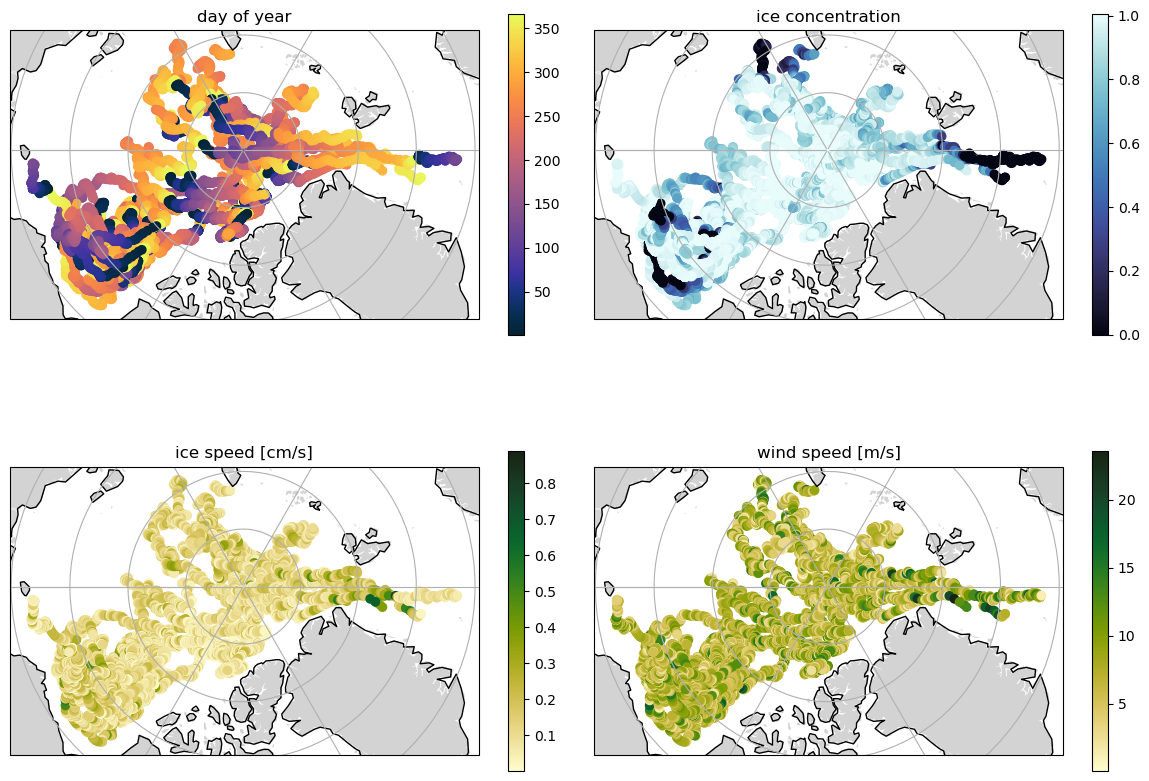

In [5]:
#(a) maps
#here we look at maps showing properties of interest at locations of the ITPs.

# Set up the figure
fig = plt.figure(figsize=(12, 10))

# Common projection: North Polar Stereographic
proj = ccrs.NorthPolarStereo(central_longitude=270)

def setup_ax(ax, title):
    ax.set_title(title)
    ax.coastlines(resolution='110m')
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    #ax.add_feature(cfeature.OCEAN, facecolor='aqua')
    ax.gridlines(draw_labels=False)

# Day of year
ax = fig.add_subplot(221, projection=proj)
setup_ax(ax, 'day of year')
sc = ax.scatter(lon, lat, c=doy, cmap=cmocean.cm.thermal, transform=ccrs.PlateCarree())
plt.colorbar(sc, ax=ax, orientation='vertical', shrink=0.6)

# Ice concentration
ax = fig.add_subplot(222, projection=proj)
setup_ax(ax, 'ice concentration')
sc = ax.scatter(lon, lat, c=ci, cmap=cmocean.cm.ice, transform=ccrs.PlateCarree())
plt.colorbar(sc, ax=ax, orientation='vertical', shrink=0.6)

# Ice speed
ax = fig.add_subplot(223, projection=proj)
setup_ax(ax, 'ice speed [cm/s]')
sc = ax.scatter(lon, lat, c=icespeed, cmap=cmocean.cm.speed, transform=ccrs.PlateCarree())
plt.colorbar(sc, ax=ax, orientation='vertical', shrink=0.6)

# Wind speed
ax = fig.add_subplot(224, projection=proj)
setup_ax(ax, 'wind speed [m/s]')
sc = ax.scatter(lon, lat, c=windspeed, cmap=cmocean.cm.speed, transform=ccrs.PlateCarree())
plt.colorbar(sc, ax=ax, orientation='vertical', shrink=0.6)

plt.tight_layout()
plt.show()

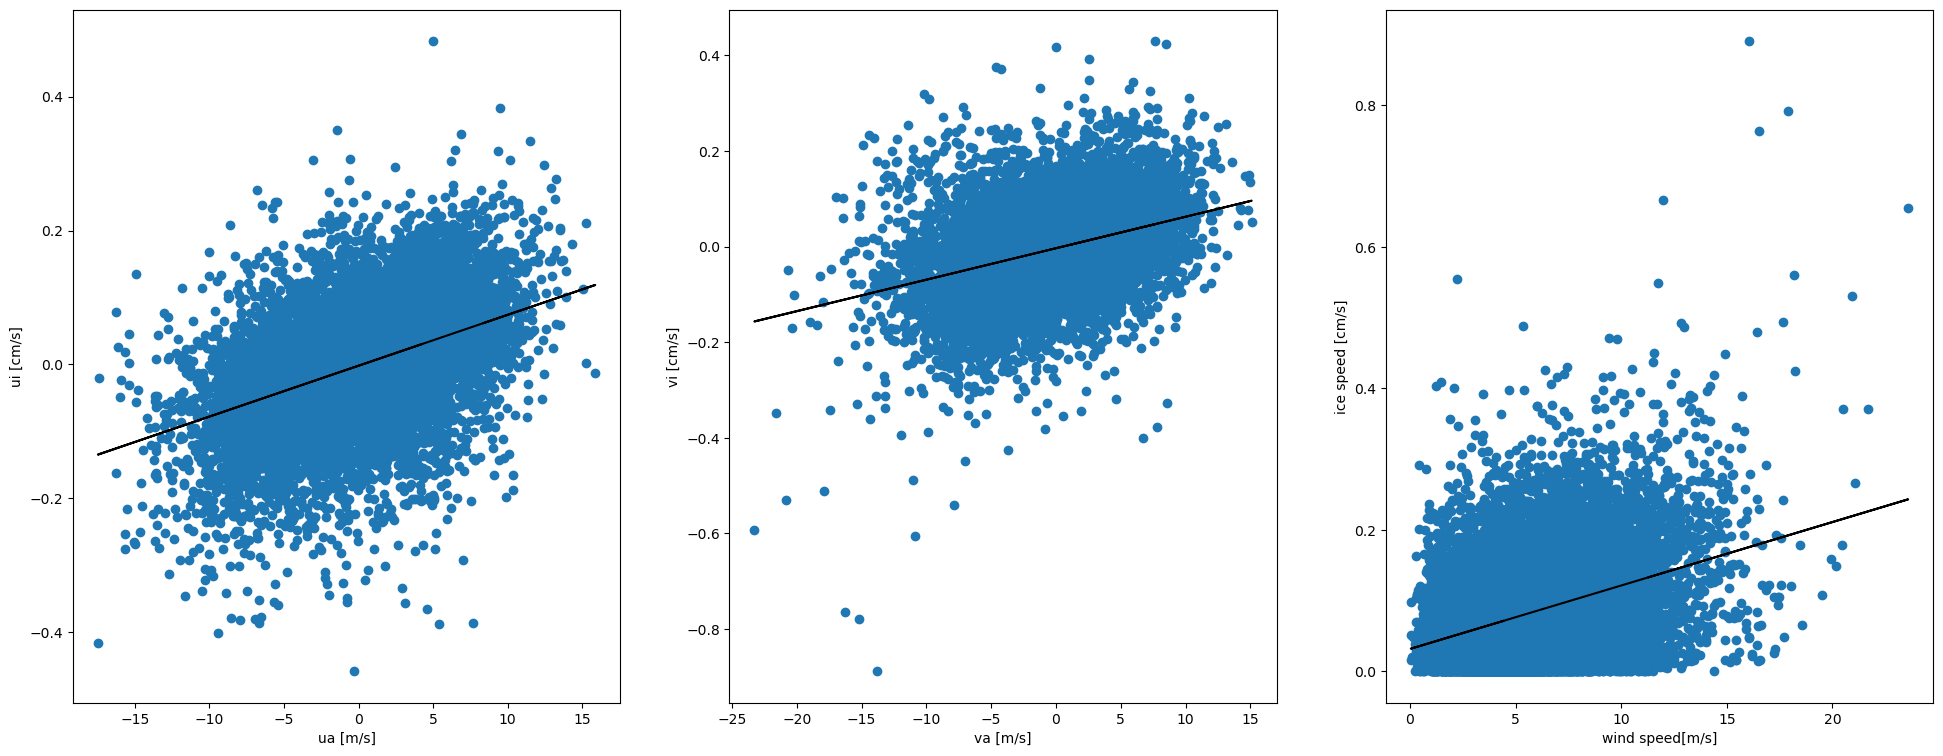

In [6]:
#(b) scatter: compare variables
#here we look at plots comparing some of the variables to get an idea of the relationships between them

fig, axs = plt.subplots(1, 3,figsize=(24,9))
axs[0].scatter(ua,ui)
axs[0].set_xlabel('ua [m/s]')
axs[0].set_ylabel('ui [cm/s]')
slope, intercept, r_value, p_value, std_err = stats.linregress(np.squeeze(ua),np.squeeze(ui))
axs[0].plot(ua,intercept+ua*slope,'-',color = 'black', label = 'LSQ: x vs y')

axs[1].scatter(va,vi)
axs[1].set_xlabel('va [m/s]')
axs[1].set_ylabel('vi [cm/s]')
slope, intercept, r_value, p_value, std_err = stats.linregress(np.squeeze(va),np.squeeze(vi))
axs[1].plot(va,intercept+va*slope,'-',color = 'black', label = 'LSQ: x vs y')

axs[2].scatter(windspeed,icespeed)
axs[2].set_xlabel('wind speed[m/s]')
axs[2].set_ylabel('ice speed [cm/s]')
slope, intercept, r_value, p_value, std_err = stats.linregress(np.squeeze(windspeed),np.squeeze(icespeed))
axs[2].plot(windspeed,intercept+windspeed*slope,'-',color = 'black', label = 'LSQ: x vs y')

## 1.4 Processing Data for ML

### 1.4.1 Partitioning Data in Training, Validation, and Test Datasets

Data are split into train, validate, and test sets before entered into a ML model, typically with an 80% - 10% - 10% split.

***Train:***  Training data is used to fit the model.

***Validate:*** The validation dataset is used to evaluate the model fit during training and update the model hyperparameters.

***Test:*** The test dataset is not seen by the model during training and use used to provide an unbias evaluation of the final model fit.


In [7]:
# we will start by concatenating all of the variables for processing
# ** this is not a necessary step, but will make it so that we only need 
# ** to apply the next few lines once instead of separately for each variable
all_data = np.concatenate((ui[:,None],vi[:,None],ua[:,None],va[:,None],ci[:,None],doy[:,None],lat[:,None],lon[:,None]),axis=1)


# set length of train, validate, and testing dataset 
# to be 80%-10%-10% of the length of the entire time series
length_train = int(0.8*all_data.shape[0])
length_val_te = int(0.1*all_data.shape[0])

# set start (0) and end (f) indices for train, validate, test
idx_tr_0 = 0
idx_tr_f = length_train
idx_va_0 = length_train
idx_va_f = length_train+length_val_te
idx_te_0 = length_train+length_val_te
idx_te_f = length_train+length_val_te+length_val_te

#train(tr) - validate(va) - test(te) data
data_te = all_data[idx_te_0:idx_te_f,:]
remaining_data = all_data[0:idx_te_0,:]

data_tr, data_va = train_test_split(remaining_data,test_size = .1, shuffle=True, random_state = 12)



### 1.4.2 Feature Scaling

#### Why do we apply Feature Scaling?
Features (or variables) that are input to a ML model may have vastly different ranges, which might cause a ML model to put more weights on variables with a larger range. Feature Scaling (either standardization or normalization) makes it so features are on similar scales.

***Standardization:*** Here, sea ice and atmospheric data is standardized to zero mean and one standard deviation (i.e. subtract mean and divide by standard deviation)

It is best practice to standardize data to the training dataset, as to prevent data leakage during ML training and testing. Data leakage happens when information outside of the training data is used to create the model, which can lead to inflated performance and poor generalization.

In [8]:
prop_train = []
prop_val = []
prop_test = []

miui = []
stdi = []

# loop through each variable
for i in range(8):
    prop_tr = data_tr[:,i]
    prop_va = data_va[:,i]
    prop_te = data_te[:,i]

    #take mean and standard deviation of training data
    miu = np.nanmean(prop_tr)
    stdev = np.nanstd(prop_tr)

    tr_standardized = (prop_tr-miu)/stdev
    te_standardized = (prop_te-miu)/stdev
    va_standardized = (prop_va-miu)/stdev
       
    prop_train.append(tr_standardized)
    prop_val.append(va_standardized)
    prop_test.append(te_standardized)

    miui.append(miu)
    stdi.append(stdev)

train_std = np.array(prop_train)
validate_std = np.array(prop_val)
test_std = np.array(prop_test)

miu_tr = np.array(miui)
std_tr = np.array(stdi)



# 2. Neural Network

In this section we select the data for our ML model (section 2.1), and define the ML model hyperparameters (sections 2.2 and 2.3). In the last section we build and evaluate the ML model (section 2.4).

## 2.1 Select Inputs and Outputs

In [9]:
# outputs (Y) = sea ice velocity
y_train = train_std[:2,:].T
y_val = validate_std[:2,:].T
y_test = test_std[:2,:].T

#inputs (X) = wind velocity, sea ice concentration, day of year, latitude, longitude
x_train = train_std[2:,:].T
x_val = validate_std[2:,:].T
x_test = test_std[2:,:].T


## 2.2 Define Custom Metrics and Loss Functions

What is a loss function?

The cost / loss function evaluates the difference between the model prediction and the true data during training.


In [10]:
#define NRMSE function
def norm_root_mean_squared_error(y_true,y_pred):
    return  (K.sqrt(K.mean(K.square(y_pred - y_true))))/((K.std(y_true)))

#define pearson correlation
def corr(y_true, y_pred):
    return (K.sum((y_true-K.mean(y_true))*(y_pred-K.mean(y_pred))))/((K.sqrt(K.sum(K.square(y_true-K.mean(y_true)))))*(K.sqrt(K.sum(K.square(y_pred-K.mean(y_pred))))))

## 2.3 Define Model Hyperparameters

In [11]:
# Here are some model hyperparameters we can edit

# LOSS FUNCTION
LOSS = norm_root_mean_squared_error # Loss Function used
METRIC = corr # Metric for assessing model skill

# MODEL TRAINING
N_UNITS = 32 # number of nodes in layer
NUM_EPOCHS = 100 # Max number of times all of the data will be seen iteratively in training
BATCH_SIZE = 200 # Number of samples per epoch
LEARNING_RATE = .01 # Learning rate (think step size)
DROP = 0.2 # dropout rate
ACTIVATION_FUNCTION = 'relu' #activation function
OPTIMIZER = 'adam' #gradient descent algorithm


## 2.4 Building a Neural Network: Deep NN w/ hidden layers

### 2.4.1 Compile and train the model

Epoch 1/100
70/70 [==============================] - 0s 2ms/step - loss: 0.9829 - corr: 0.2926 - val_loss: 0.9011 - val_corr: 0.4348
Epoch 2/100
70/70 [==============================] - 0s 540us/step - loss: 0.8736 - corr: 0.4887 - val_loss: 0.8583 - val_corr: 0.5145
Epoch 3/100
70/70 [==============================] - 0s 517us/step - loss: 0.8475 - corr: 0.5318 - val_loss: 0.8424 - val_corr: 0.5398
Epoch 4/100
70/70 [==============================] - 0s 526us/step - loss: 0.8340 - corr: 0.5539 - val_loss: 0.8347 - val_corr: 0.5525
Epoch 5/100
70/70 [==============================] - 0s 514us/step - loss: 0.8266 - corr: 0.5647 - val_loss: 0.8290 - val_corr: 0.5603
Epoch 6/100
70/70 [==============================] - 0s 501us/step - loss: 0.8217 - corr: 0.5734 - val_loss: 0.8242 - val_corr: 0.5677
Epoch 7/100
70/70 [==============================] - 0s 722us/step - loss: 0.8182 - corr: 0.5775 - val_loss: 0.8216 - val_corr: 0.5712
Epoch 8/100
70/70 [==============================] - 0s 5

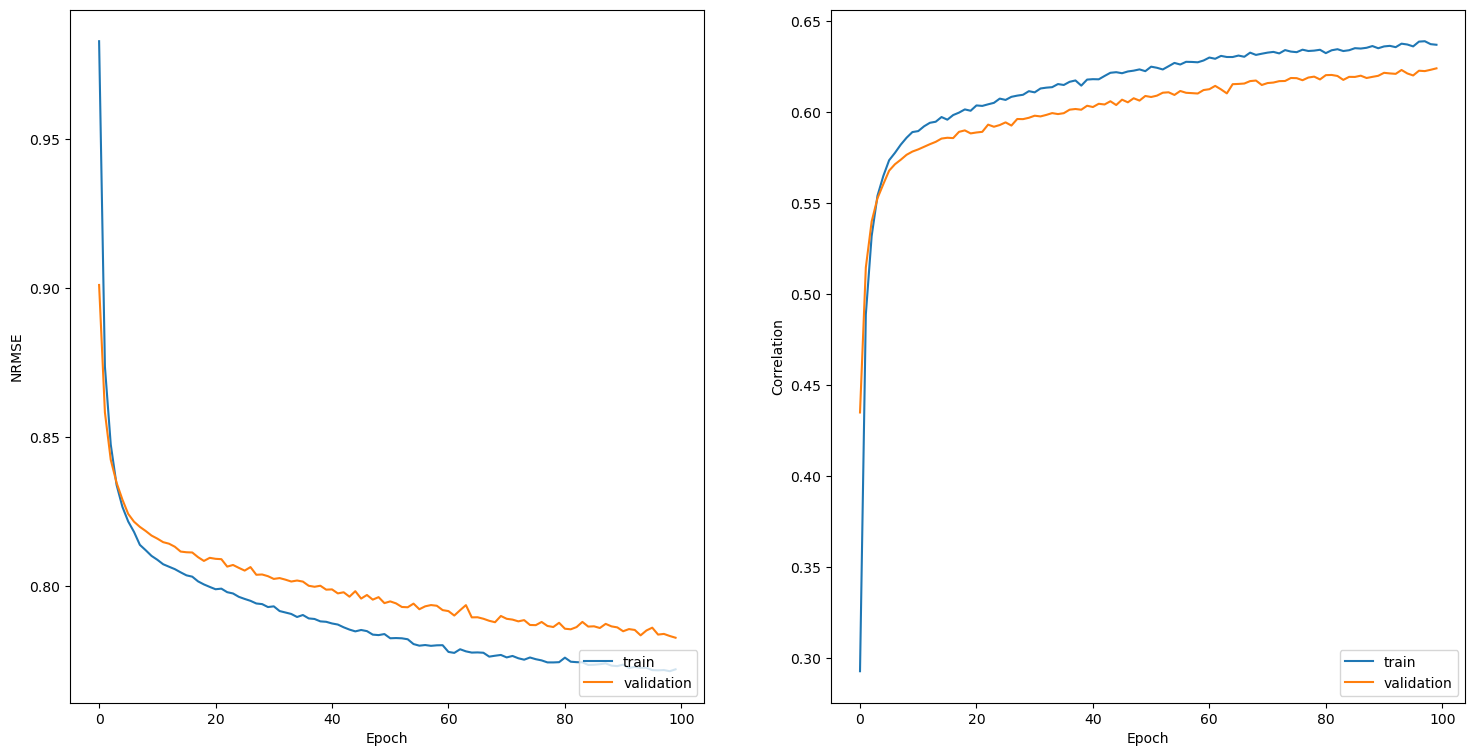

In [12]:
# Example: build a fully-connected network

# In Keras a NN model is built in layers
# Most common type is sequential layers - one layer after the other with
# connections only between neighboring layers.

[nd,nch] = y_train.shape #shape of training data

# define the model
model = tf.keras.Sequential()
model.add(layers.Dense(N_UNITS,activation=ACTIVATION_FUNCTION))
model.add(layers.Dense(nch,activation=None))

#compile and train model
model.compile(optimizer=OPTIMIZER,loss=LOSS ,metrics=[METRIC])

# train the model
history = model.fit(x_train,y_train,epochs=NUM_EPOCHS,batch_size=BATCH_SIZE,shuffle=True,validation_data=(x_val,y_val))
print(history)
print(model.summary())

#evaluate model: plot the loss during training
plot1 = plt.figure(1,figsize=(18,9))
plt.subplot(1,2,1)
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='validation')
plt.xlabel('Epoch')
plt.ylabel('NRMSE')
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(history.history['corr'],label='train')
plt.plot(history.history['val_corr'],label='validation')
plt.xlabel('Epoch')
plt.ylabel('Correlation')
plt.legend(loc='lower right')
plt.show()


### 2.4.2. Evaluate and Visualize Model Predictions

Made predictions with the model using the test dataset

In [13]:
# make predictions with your model using the test dataset
y_true = y_test
y_pred = model.predict(x_test)

54/54 [==============================] - 0s 290us/step


Evaluate model performance (correlation and skill)

In [14]:
skill = 1 - (np.sqrt(np.mean(np.square(y_pred - y_true))))/((np.std(y_true)))
corre = (np.sum((y_true-np.mean(y_true))*(y_pred-np.mean(y_pred))))/((np.sqrt(np.sum(np.square(y_true-np.mean(y_true)))))*(np.sqrt(np.sum(np.square(y_pred-np.mean(y_pred))))))

print('skill:',skill)
print('correlation:',corre)

skill: 0.20720479964924288
correlation: 0.616556495452142


Plot model evaluations: (a) scatter of true vs. predicted

Text(0, 0.5, 'predicted value')

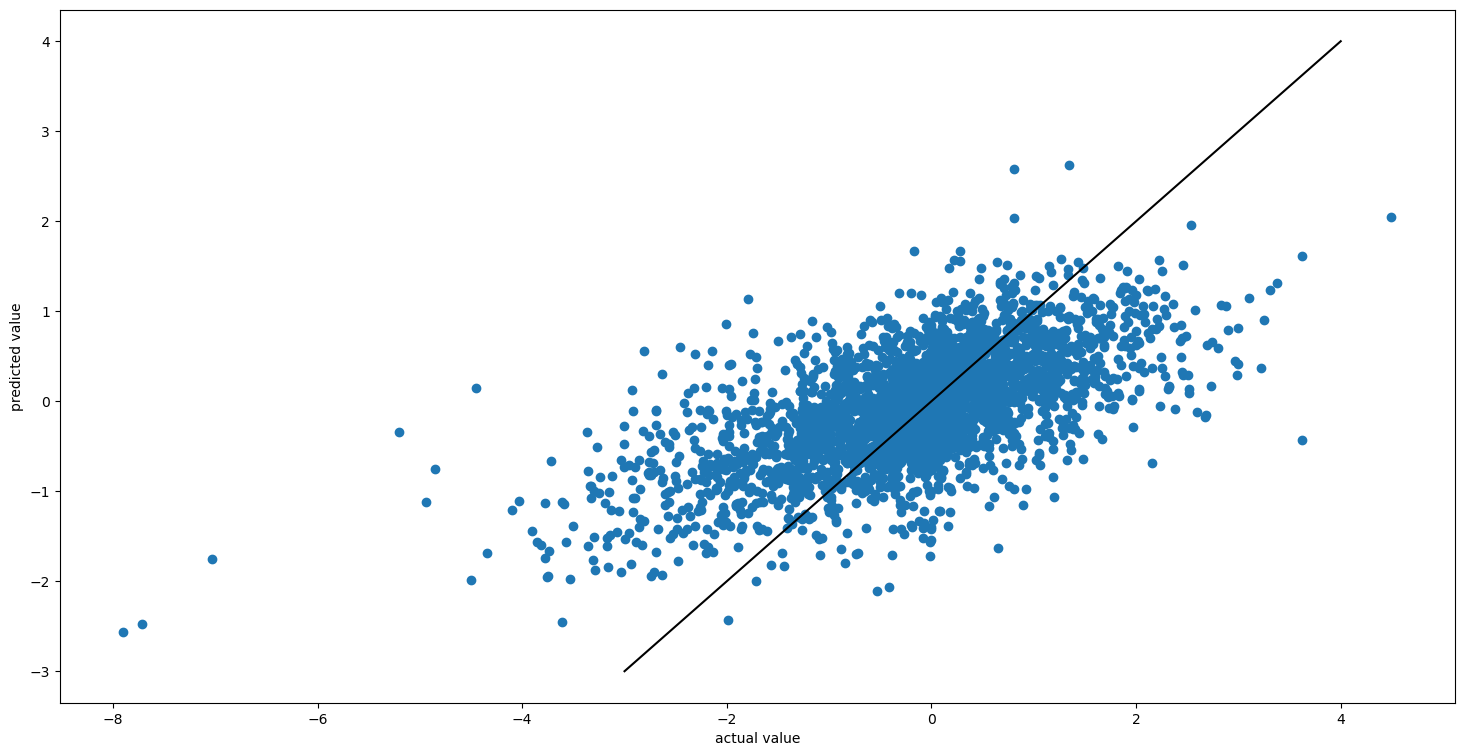

In [15]:
# (a) scatter of true vs. predicted
plt.figure(figsize=(18,9))
plt.scatter(y_true,y_pred)
plt.plot([-3,4],[-3,4],color='black')
plt.xlabel('actual value')
plt.ylabel('predicted value')